*SIO221a Notes - Alford and Gille*

*Reading:  Bendat and Piersol, Ch. 4 (esp. section 4.6)*

Concepts Covered: Confidence intervals, distinguishing between PDFs, model fitting with sines and cosines, orthogonality


## Lecture 5:  

### **Recap**
Key concepts from last time focused on the standard error of the mean
and its links to error propagation, the chi-squared and Rayleigh distributions,
and methods for telling whether one pdf is statistically like another
(the Komogorov-Smirnov test and the chi-squared test).

You'll recall that the Rayleigh distribution represents the square
root of two independent Gaussian components, $y=\sqrt{x_1^2 + x_2^2}$.

$$
p(y)=\frac{y}{\sigma^2} \exp{\left[-\frac{y^2}{2\sigma^2} \right]}. \hspace{3cm} (1)
$$

And the $\chi^2$ distribution represents the sum of $n$ squared
variables:

$$
\chi_n^2 = z_1^2 + z_2^2 + z_3^2 + ... + z_n^2.\hspace{3cm} (2)
$$

We looked at examples of these, and we noted that the $\chi^2$ distribution
has a mathematical formulation in terms of the $\Gamma$ function.  I glossed
over the definition of the $\Gamma$ function, because it's not very
mathematically tractable, and is normally handled via a look-up table.

**Confidence intervals for Gaussian and $\chi^2$ distributions**

Before we do this, we got started on estimating confidence intervals.  Generally, a 95% confidence interval is defined (according to MHA) as "the minimum and maximum values bracketing the range over which we can be 95% certain a random variable will take." We can specify different intervals (e.g. 90% or other) but 95% seems to be the most common.

For a Gaussian, it's straightforward to do this - recall our earlier lecture where we stated for example that 68% of values from a Gaussian distribution are within one standard deviation of the mean.  Therefore, if we have a Gaussian distribution with a mean of 2 and a standard deviation $\sigma$ of 1, we could give the 68% confidence intervals as [1,3]. Note they are symmetric about the mean so we could also just say 2 $\pm$ 1.  The 95% confidence intervals are $2\sigma$ for a Gaussian, so we could give these as 2 $\pm$2.

And recall our discussion of the standard error of the mean: if we are not happy with these error bars, we can usually average to reduce the standard deviation and therefore improve our confidence limits.

Recall though that many quantities, particularly error-related ones, are not Gaussian, and that the $\chi^2$ distribution is key.  We'll cover this more when we get to estimating errors in our spectra.  But since the spectrum is an energy-like quantity and therefore involves the sum of squares of things, we can understand why it would be $\chi^2$. 

So let's do a quick example of computing the confidence limits for the $\chi^2$ distribution using the code from last time:

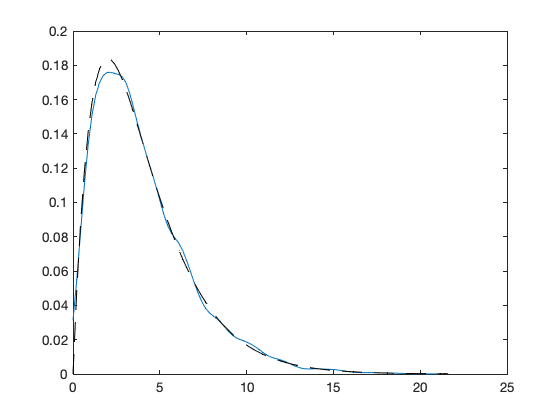

In [46]:
%% 
%Now take n and look at the sum of the squares rather than the square root,
%to look at the chi2 distribution.

n=4;
N=10000;
sigma=1;
output_var=zeros(N,1);
for c=1:n
    output_var=output_var + sigma*randn(N,1).^2;
end

chi2var=output_var;
vals=linspace(0,max(chi2var),100);

pdf=ksdensity(chi2var,vals);
chi2_analytical = 1./2.^(n/2)./gamma(n/2).*exp(-vals/2).*vals.^(n/2-1);
%chi_mha=1./(2.^(n/2)*gamma(n/2))* vals.^(n/2-1).*exp(-vals./2);

%plot(vals,chi2_analytical,vals,chi_mha)
plot(vals,pdf,vals,chi2_analytical,'k--')



Now we want the cumulative distribution to estimate confidence limits, so let's integrate.
Note we could also use MATLAB's chi2cdf function, but we are computing it ourselves for instruction here.

In [51]:
dv=mean(diff(vals));
cdf=cumsum(chi2_analytical)*dv;

%Demonstrate use of MATLAB function:
cdf_matlab=chi2cdf(vals,n);

%Then finding the 95% confidence intervals is as simple as locating the values for which the CDF is 0.025 and 0.975:


cl =

    0.4366


cu =

   11.1325


mn =

    3.9899



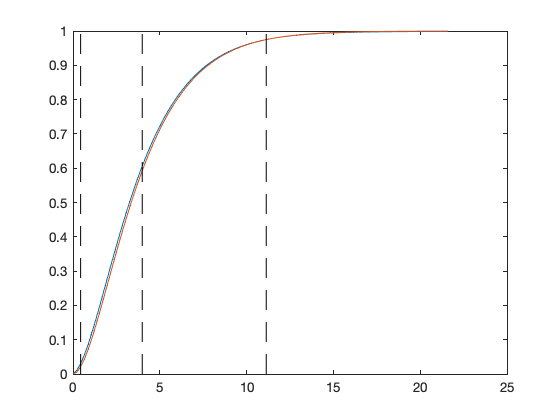

In [52]:
ilower=find(cdf > 0.025,1,'first');
iupper=find(cdf > 0.975,1,'first');

cl=vals(ilower)
cu=vals(iupper)

mn=mean(chi2var)

%Then add these to the plot!

plot(vals,cdf,vals,cdf_matlab)

%freqline is aa little utility for plotting a dashed vertical line at the specified value.  
%It's in the repo.

freqline(cl);
freqline(cu);
freqline(mn);

%And we can add the mean value

Note the asymmetry between the upper and lower values because it's not a Gaussian distribution.  So we'd then report "the mean is 3.9, with 95% confidence interval of {0.5,11.3}."  

And of course, as in the case of the example above, averaging gives us more squared quantities being added together which increases the number of degrees of freedom, reducing the confidence range towards more acceptable values.

Finally, note the mean is not at the mode or most likely value, a sign of a "long-tailed distribution":

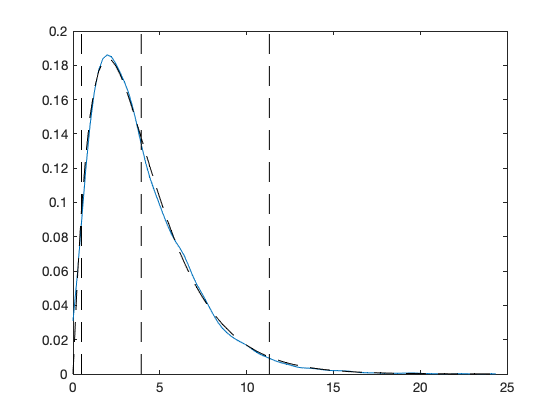

In [17]:
plot(vals,pdf,vals,chi2_analytical,'k--')
freqline(cl);
freqline(cu);
freqline(mn);


**Are two pdfs different?**

So now let's return to the heart of our problem.  How do we tell if two
pdfs differ?  We've already noted that two data sets can look wildly different
but still have the same mean and variance, so clearly we need something more
than just the mean and variance.
We can go back to our Gaussian overlaid on empirical pdf
and eyeball the difference to say that they're close enough, or not
plausibly similar.  We can evaluate whether the mean and standard deviation
differ.  All of this is good, but it doesn't exploit the full range of
information in the pdf.   We
need a metric to measure how different two distributions are.

Here are a couple of strategies.  One notion is to ask about the largest
separation between 2 pdfs.  We compute two cdfs---in this case one
empirical and one theoretical, but we can also do this with two empirical
cdfs.  We find the maximum separation between the distributions, the Komogorov-Smirnov statistic:

$$
D_n = \sup_n \left| C_n(x) - C(x)\right|\hspace{3cm} (22)
$$

and then we can predict the probability that a data set with $n$ elements
should differ from the ideal distribution by $D_n$. The module `scipy.stats` has a the function [`kstest`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html)
that sorts through the parameters for this.  However, we have to be careful
with this, because usually our data are correlated, and we don't have as
many degrees of freedom as we think.  The easiest solution is to decimate
the data set so that the number of elements reflects the number of
degrees of freedom.

If you have one data set, and want to
know whether it is plausibly Gaussian, put all the data
in a vector $\bf{x}$, and in Python use the function ``kstest(x)`` from ``scipy.stats``.
In Python, the function ``kstest`` outputs the actual statistics as oposed to a binary answer (which is the case in Matlab). To decide wheter of not to reject the null hypothesis you have to look at both the KS statistics and the p-value. So for example, if we want to test if an array of Gaussian noise has a Gaussian
distribution, we could type:

In [1]:
kstest(randn(10000,1))


ans =

  logical

   0



which produces 0.  For a non-Gaussian (uniform distribution) of random numbers

In [2]:
kstest(rand(10000,1))


ans =

  logical

   1



produces 1, implying that the input vector is not Gaussian.

If we're comparing two data sets, we can make two vectors (e.g. $x$ and $y$), and use

``kstest2(x,y)``

Again, an output
of 0 says plausible the two records come from the same ``true'' distribution;
output of 1 says that at the 5\% significance level,
 you can reject the null hypothesis that $x$ and $y$ come from the same
general source.
Compare these two cases:

In [8]:
x=randn(10000,1);
y=randn(10000,1);
kstest2(x,y)


ans =

  logical

   0



In [7]:
x=randn(10000,1);
y=rand(10000,1);
kstest2(x,y)


ans =

  logical

   1



These are fine, but unless you dive into the details of the KS test they may be a little unsatisfactory.  A second strategy is to bin the data and ask whether the number of
data in the bin is consistent with what we'd expect, using $\chi^2$
statistics because we're looking at the mean square difference at each value between our distribution and the one in question.  

In this case for comparisons with a theoretical pdf,

$$
\chi^2 = \sum_i\frac{(N_i-n_i)^2}{n_i},\hspace{3cm} (3)
$$

where $N_i$ is the observed number of events in bin $i$, and $n_i$ is the theoretical
or expected number of events in bin $i$.
For comparisons between two distributions,

$$
\chi^2 = \sum_i\frac{(N_i-M_i)^2}{N_i+M_i},\hspace{3cm} (4)
$$

where $N_i$ and $M_i$ are each observed numbers of events for bin $i$.
The values of $\chi^2$ are evaluated using the $\chi^2$ probability function $Q(\chi^2|\nu)$, which is an incomplete gamma function,
where $\nu$ is the number of bins (or the number of bins minus one, depending on
normalization).  In Python this is:

``scipy.special.gammainc(nu/2, chi_squared/2)``

or equivalently

``scipy.stats.chi2.cdf(chi_squared, nu)``

And in Matlab this is
``gammainc(chi_squared/2,nu/2)``

or equivalently
``chi2cdf(chi_squared,nu).``


To test this out, you can produce a few sets of binned random data.  (Be sure to
use the same bins for each record.)

In MATLAB, you'd code this as follows:

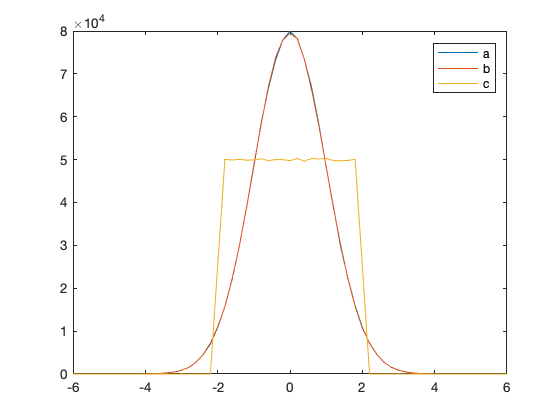

In [6]:
vals=-6:.1:6;
N=100000;
%We first do two Gaussian populations with equal mean and variance:
[a1,a2]=hist(randn(N,1),vals);
[b1,b2]=hist(randn(N,1),vals);

%Then compare to a uniform distribution.
[c1,c2]=hist(4*rand(N,1)-2,vals);

%We can also try for a distribution closer to the original one:
%
%[c1,c2]=hist(1.2*randn(N,1),vals);


a1pdf=a1./sum(a1);
b1pdf=b1./sum(b1);
c1pdf=c1./sum(c1);


%plot(vals,a1pdf,vals,b1pdf,vals,c1pdf);legend('a','b','c')
plot(vals,a1,vals,b1,vals,c1);legend('a','b','c')

The tests produce the following:

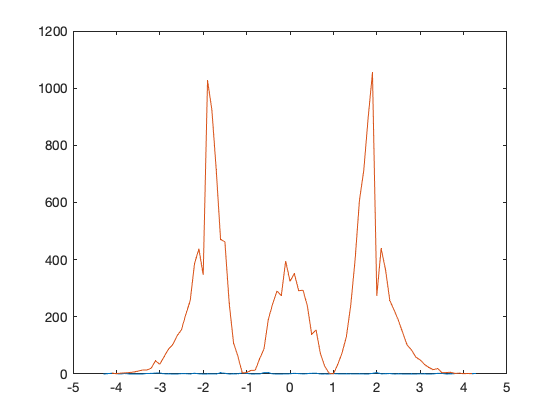

In [3]:
%Now from B&P 4.5.1, the chi2 statistic is the sum of the following:
plot(vals,(b1-a1).^2 ./(a1+b1),...
vals,(c1-a1).^2 ./(a1+c1))

That is, the sum should be a chi squared variable since it's the sum of squares. Therefore, we can use the CDF of the chi2 distribution to see if that value is consistent with expectations.


chi2ab =

   94.6181


ans =

    0.0364


chi2ac =

   1.6261e+04


ans =

     1



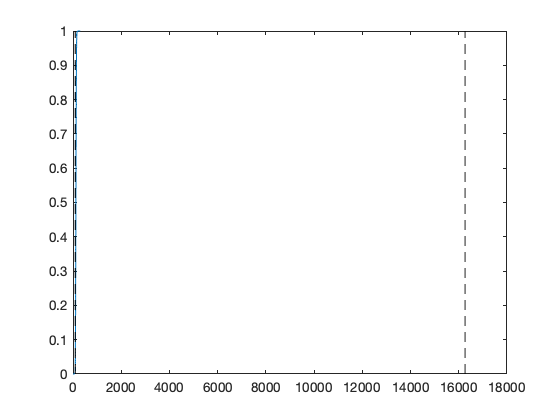

In [4]:
chi2ab=nansum((b1-a1).^2 ./(a1+b1))

%Since we sum over n values, that is the number of degrees of freedom.
n=length(vals);
chi2cdf(chi2ab,n)

chi2ac=nansum((c1-a1).^2 ./(a1+c1))
chi2cdf(chi2ac,n)


valsp=1:300;
plot(valsp,chi2cdf(valsp,n))
freqline(chi2ab);
freqline(chi2ac);

%chi2=nansum((c1-a1).^2 ./(c1+a1))
%chi2cdf(chi2,25)
%gammainc(chi2/2,25/2)

If the data sets are similar at least at the 95\% level, 
then we expect the actual value to be below the 95th percentile of a $\chi^2$ variable. 


#### Expanding our models: sines and cosines.

You're going to get lots more about fitting models in 221b.  Still, it's useful to extend the linear trend model we used before to something a little more useful for data that has cycles in it.  Let's recall our pressure time series, which we'll again grab with our handy function.


pier = 

  struct with fields:

           dnum: [2156x1 double]
    temperature: [2156x1 single]
       pressure: [2156x1 single]
         readme: '2020 Pier data, SIO221a, function Get2020PierData.m'



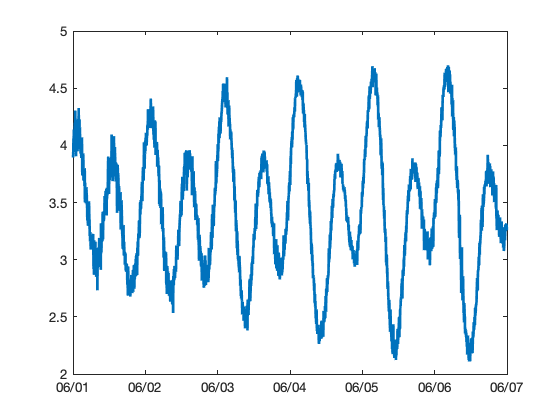

In [146]:
%First we can add it to our path:
addpath('/Users/malford/GoogleDrive/Work/Projects/Teaching/sio221a/SIO221a_Github_code/') %You might need to modify this depending on your path and current directory.
pier=Get2020PierData(datenum(2020,6,1,0,0,0),datenum(2020,6,7,0,0,0))

time=pier.dnum; %units of days
data=pier.pressure;
plot(time,data,'LineWidth',2)
datetick


##### Building complexity:   oscillatory signals


As we noted in Lecture 1, if we want to find a trend, we define ${\bf A}$ to have
a column of ones (to identify the mean) and a column containing the time,
to identify the rate of change.  We can make our model ${\bf A}$
progressively more complicated by adding additional columns.
What do we do if we want to find oscillatory cycles?   

Before I give you any answers, take a moment to think about
this. Refer back to the lecture 2 notes for fitting trends and see what ideas you come up with.



We could use:
$$
   {\bf A}= \left[\begin{array}{ccc}
                              1 & \cos(t_r) & \sin(t_r) \\
                              \vdots & \vdots & \vdots  \end{array}\right],\hspace{3cm} (14)
$$

where time $t$ is measured in days, and $t_r=2\pi t/P$, where $P=12.4/24$ is the semidiurnal tidal period, is the time in radians.

We need the sine and cosine because we don't know the phase of
our cycle exactly.  You might imagine that we could fit for the
phase (e.g. $\sin(t_r + \phi)$), and we could, but that would be a non-linear
fitting process, and the power of least-squares fitting won't work if we
try that---we'd quickly be plunged into the murky world of non-linear
fitting procedures, which is messy, unreliable, and not necessary in this case.  

Now let's think about the pressure record from the Scripps pier, because
we know that had a lot of sinusoidal variability.  What might we include
in that fit?  We might hypothesize that data collected on the pier
could be influenced by an annual cycle (1 cycle/365.25 days), a diurnal
cycle (1 cycle/24 hours), and a tidal cycle (1 cycle/0.5175 days =
1 cycle/(12 hours + 25.2 minutes)).  How would we fit for all of these
components?

What is the maximum number of sinusoidal cycles that we can resolve in N points? One possibility would be that the maximum is N cycles per N points. That would require a full sinusoidal oscillation squeezed between data element 1 and data element 2. But if you think about it, we wouldn’t expect to have enough information to determine the amplitude of a sine wave that had to squeeze itself between consecutive observations. Moreover if N cycles per N points were the maximum, this would mean that we’d be solving for 2N coefficients with only N data points. Clearly that would require more information than we have available.
So the maximum must be less than N. There are two ways to think about this. One way is to think about the information content of our data. At the most basic level, if I have N elements in my data matrix, then at best, I can hope to have N independent equations, so I can fit N coefficients as an exactly determined problem. So I can solve for frequencies from 0 cycles per N points to N/2 cycles per N points, with 2 coefficients for all but the end members of my record. The other way to think of this is to observe that you’ll need at least 2 data points per cycle to determine even a minimum amount of information about the sine or cosine amplitudes of your data. So the highest frequency that you can possibly detect of N/2 cycles per N data points. This is the Nyquist frequency and it is one of the most central concepts in time series analysis.


Here's an example in MATLAB:


P =

    0.5167



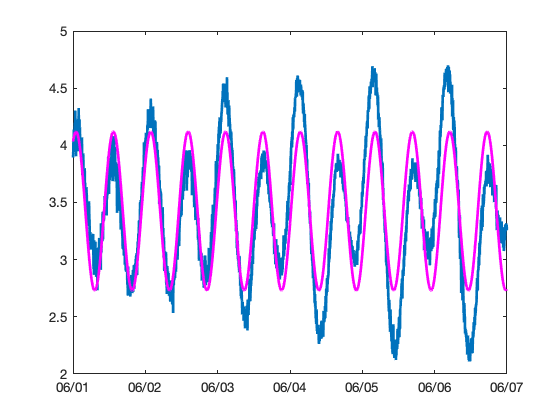

In [4]:
time=pier.dnum; %units of days
data=pier.pressure;
P=12.4/24;

%size(pier.pressure)
A2=[ones(length(time),1) sin(2*pi*time/P) ...
    cos(2*pi*time/P)];
x2=inv(A2'*A2)*A2'*data;
plot(time,data,time,A2*x2,'m','LineWidth',2)
datetick

Not bad, but we're missing something.  Any ideas?



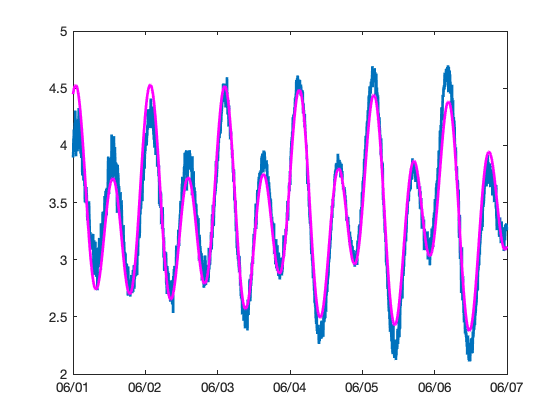

In [147]:
time=pier.dnum; %units of days
data=pier.pressure;
P=12.42/24; %semidiurnal
P1=1;  %diurnal


%size(pier.pressure)
A2=[ones(length(time),1) sin(2*pi*time/P) ...
    cos(2*pi*time/P) sin(2*pi*time/P1) cos(2*pi*time/P1)];
x2=inv(A2'*A2)*A2'*data;
plot(time,data,time,A2*x2,'m','LineWidth',2)
datetick

This was kind of a particularly good example since pressure is so dominated by these two frequencies.  What about temperature, which we looked at earlier?

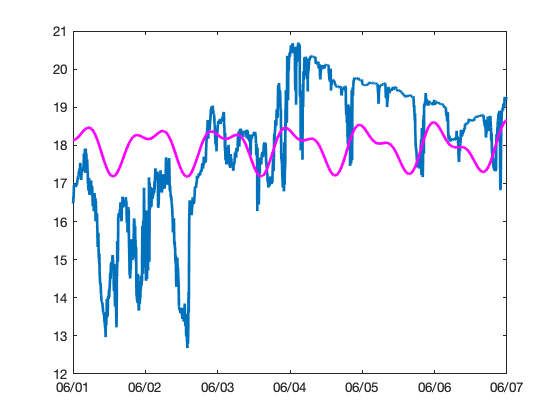

In [9]:
time=pier.dnum; %units of days
data=pier.temperature;
P=12.42/24; %semidiurnal
P1=1;  %diurnal


%size(pier.pressure)
A2=[ones(length(time),1) sin(2*pi*time/P) ...
    cos(2*pi*time/P) sin(2*pi*time/P1) cos(2*pi*time/P1)];
x2=inv(A2'*A2)*A2'*data;
plot(time,data,time,A2*x2,'m','LineWidth',2)
datetick

Any thoughts on why we're not doing very well here?  Any ideas for how to improve? (Hint: we're moving towards Fourier analysis...)

#### Orthogonality and Least-Squares Fits

Let's think about one important detail of our fitting procedure.
What would happen if we wanted to fit $T=x_1 + x_2 t + x_3 t$, that
is to fit two constants to the same variable?  In this case, clearly $x_2$
and $x_3$ are completely indistinguishable.
What happens when we try to use our redundant functions in our matrix ${\bf A}$?
$$
{\bf A}=\left[\begin{array}{ccc} 1 & t_1 & t_1 \\
                           1 & t_2 & t_2 \\
                           \vdots & \vdots & \vdots \\
                           1 & t_N & t_N \end{array}\right].\hspace{3cm} (15)
$$

Then we find:

$$
{\bf A}^T{\bf A} = \left[\begin{array}{ccc} N & \sum t_i & \sum t_i \\
                               \sum t_i & \sum t_i^2 & \sum t_i^2 \\
                               \sum t_i & \sum t_i^2 & \sum t_i^2
        \end{array}\right].\hspace{3cm} (16)
$$

The second and third rows of ${\bf A}^T{\bf A}$ are identical, which tells us that
the third row is adding no additional information to the system.  As a
result, the matrix ${\bf A}^T{\bf A}$ is singular, and we won't be able to find an
inverse for it.

You probably wouldn't try to
fit coefficients to two identical functions, but you might do something that
was fairly similar.
For example, $T=x_2 t_r + x_3 \sin(t_r)$ poses a similar problem when $t_r$ is
near zero.  In this case, the rows of ${\bf A}^T{\bf A}$ might not be identical, but
they might be nearly the same so that Matlab would give you an error
message.

Similarly, you'll have trouble if you try:  $T=x_1 +x_2 t_r + x_3 (1+t_r)$.

None of this was an issue when we used  sine and cosine, because
they are **orthogonal**, so they contain no redundant information.  What do we mean by that?

#### Least-Squares Fitting Sines and Cosines

Least-squares fitting is particularly tidy when the functions that we use
for our fit, the columns of our matrix ${\bf A}$, are completely orthogonal,
because then
the fit to one function has no impact on the fit to the other functions.

Consider the special case where the columns of ${\bf A}$ are made up of sines and
cosines, so
$$
A = \left[\begin{array}{cccccc} 1 & \cos(\omega t) & \sin(\omega t) &
\cos(2\omega t) & \sin(2\omega t) & \cdots \\
 \vdots & \vdots & \vdots & \vdots & \vdots & \end{array}\right],
$$

where $\omega = 2\pi/T$ and $T$ is the total duration of the data record.
The dot product of any two columns $i$ and $j$ of ${\bf A}$ is zero if $i\ne j$.
If I have data at $N$ evenly spaced time increments, $t_1, t_2, ... t_N$,
then this orthogonality property holds for all frequencies from $\omega$
through $N\omega/2$.  Since I have a sine and cosine at each frequency
(up to frequency $N\omega/2$ where sine might be zero at all points in
time), this means that I can define a total of $N$ independent orthogonal
columns in ${\bf A}$.


#### Orthogonality and Sines and Cosines

Last time we talked about the importance of having independent columns in our matrix ${\bf A}$ and noted
that sines and cosines are particularly useful since they are orthogonal.  Let's work through this
a little more carefully.

Consider a record of duration $T$.  I can imagine squeezing into the
period $T$, one sine wave, or two, or three, or four.  How do I tell if my records are
orthogonal?

$$
\int_0^T \sin\left(\frac{2\pi n t}{T}\right) \sin\left(\frac{2\pi m t}{T}\right)\, dt 
$$

$$
=  \frac{1}{2} \int_0^T \cos\left(\frac{2\pi (n-m)t}{T}\right) -
\cos\left(\frac{2\pi (n+m)t}{T}\right) \, dt
$$

$$
  =  \frac{1}{2} \frac{T}{2\pi} \left.\left[ \frac{\sin\left(\frac{2\pi (n-m)t}{T }\right)}{n-m}- \frac{\sin\left(\frac{2\pi  (n+m)t}{T}\right)}{(n+m)}\right]\  \right|_0^T \\
  $$

$$
 = 
$$

$$
\begin{cases}
0, \mbox{if $n\ne m$}\\
\frac{T}{2}, \mbox{if $n=m$}
\end{cases}
$$
 

(What matters is that this is only non-zero in the special case when $n=m$.  For the
moment, the fact that the integral yields $T/2$ when $n=m$ is a minor detail.)
By extension the same applies for two cosines, or a sine multiplied by a cosine.